In [20]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import cytoflow as flow
import torch
from collections import Counter

### Pre Processing

Using the data set from (https://github.com/CaRniFeXeR/python4FCM_Examples/ ) and following the preprocessing steps using the customised python package cytoflow, the event matrix was created as a time series of data matrix for number of samples at a given time (rows) for a given marker (columns). The event matrix and markers are the required preprocessing from the paper: Automated identification of cell populations in flow cytometry data.  We deviate from the processing within the github by not limiting any of the time series 

In [21]:
basepath = "./data/"
tube1 = flow.Tube(file = basepath + '494.csv')
ex = flow.ImportOp(tubes = [tube1]).apply()

cd19_thresh = flow.ThresholdOp(name = "CD19pos",channel = 'CD19', threshold = 1.5)
ex2 = cd19_thresh.apply(ex)

human_conditions = flow.BulkConditionOp(conditions_csv_path =  basepath + '494_labels.csv',
                                      combine_order = ["syto", "singlets", "intact","cd19", "blast"],
                                      combined_conditions_name="human_gt",
                                      combined_condition_default ="other")

ex3 = human_conditions.apply(ex2)




ex3.data is a pandas data frame, thanks to the python package cytoflow. The target for predicition is the manual gating which is the last column in the data fram "human_gt". There are 6 options. ['blast', 'cd19', 'intact', 'other', 'singlets', 'syto']

the next steps for preprocessing is to drop the other labels and only retain the manual gating and label encode the manual gating with 
    Label Mapping: {'blast': 0, 'cd19': 1, 'intact': 2, 'other': 3, 'singlets': 4, 'syto': 5} 

In [22]:
df = ex3.data 

df.drop(["syto", "singlets", "intact","cd19", "blast", "CD19pos", "index", "allevents","erythropoiesis", "cd20"], axis=1, inplace= True)
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical column
df['human_gt'] = label_encoder.fit_transform(df['human_gt'])

# Separate features and labels
X = df.drop('human_gt', axis=1).values
y = df['human_gt'].values

label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))



X is a numpy array of shape (83411,12) and y is a numpy array of size (83411,) for the CNN we need to shape X into an array of (83411,1,12) this is the shape needed for 1D convolution, it retains the flow cytometry data for a given point in time this way. 

In [23]:
X = X.reshape(83411,1,12)
X.shape

(83411, 1, 12)

### Model Creation 

We now move onto intializing weights, the 1D CNN, evaluation metrics and epochs

In [24]:
"""
Initialise weights of given module using Kaiming Normal initialisation for linear and convolutional layers, and zeros for bias.
"""

def init_weights(module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(module.weight, mode="fan_in", nonlinearity="relu")
        if module.bias is not None:
            nn.init.zeros_(module.bias)


In [25]:
class BasicCNN2LSTM(nn.Module):
    """
    Simple CNN model with an LSTM layer
    """
    def __init__(self, dropout) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool1d(2)
        )
        self.layer2 = nn.Flatten()
        
        # LSTM layer (assuming input sequence length and features are appropriate)
        self.lstm = nn.LSTM(input_size=320, hidden_size=128, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(128, 6)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        # Reshape for LSTM (LSTM expects input of shape (batch, seq_len, input_size))
        # Assuming that the flattened output shape is (batch, seq_len, input_size)
        out = out.unsqueeze(1)  # Add sequence dimension for LSTM
        
        lstm_out, _ = self.lstm(out)  # Get LSTM output
        lstm_out = lstm_out[:, -1, :]  # Get the last time step's output
        
        out = self.fc(lstm_out)  # Final fully connected layer
        return out

In [26]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    print(X_train.shape)

(66728, 1, 12)


In [27]:
from collections import Counter
class_counts_dict = dict(Counter(y_train))

print(class_counts_dict)

{1: 3367, 0: 27339, 2: 31330, 3: 2371, 5: 1630, 4: 691}


In [28]:
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32) #Just use float 32
y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)


In [29]:
def compute_acc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return {"Accuracy": acc, "F1 Score": f1, "Precision": precision, "Recall": recall}

def evaluation_metrics(y_true: np.ndarray, y_preds: np.ndarray):
    conf_matrix = confusion_matrix(y_true, y_preds)
    accuracy, f1, precision, recall = (
        accuracy_score(y_true, y_preds),
        f1_score(y_true, y_preds, zero_division=0.0, average="macro"),
        precision_score(y_true, y_preds, zero_division=0.0, average="macro"),
        recall_score(y_true, y_preds, zero_division=0.0, average="macro"),
    )
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
    }, conf_matrix


@torch.inference_mode()
def perform_inference(model, X, y, device: str, loss_fn=None):
    """
    Perform inference on given dataset using given model on the specified device. If loss_fn is provided, it also
    computes the loss and returns [y_preds, y_true, losses].
    """
    model.eval()  # Set the model to evaluation mode, this disables training specific operations such as dropout and batch normalization
    y_preds = []
    y_true = []
    losses = []
    
    X,y = X.to(device), y.to(device)
    
    y = y.long()
    print("[inference.py]: Running inference...")
    
    outputs = model(X) 

        # Compute loss
    loss = loss_fn(outputs, y)

        # Compute metrics    
    preds = outputs.argmax(dim=1)
        
    y_preds.append(preds.cpu().numpy())
    y_true.append(y.cpu().numpy())
    losses.append(loss.item()) 
        
    # Compute average loss for the epoch
    loss_val = np.mean(losses)
        
    model.train()  # Set the model back to training mode
    y_true, y_preds = np.concatenate(y_true), np.concatenate(y_preds)
    return y_true, y_preds, loss_val if losses else None

In [30]:
n_epochs = 400
best_loss_val = float("inf")
epoch_metrics = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN2LSTM(dropout=0.3).to(device)
class_counts = np.bincount(y_train.numpy()) 
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32).to(device)
optimiser = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)
print(model)

total_acc=[]
total_pre=[]
total_rec=[]
total_f1=[]
total_loss =[]
val_total_acc = []
val_total_pre = []
val_total_rec = []
val_total_f1 = []
val_total_loss = []
for epoch in range(n_epochs):
    model.train()  
    
    # Initialize lists to store metrics
    losses = []
    y_preds = []
    y_trained = []
    inputs, labels = X_train, y_train 
    labels = labels.long()
    
    outputs = model(inputs) 

    # Compute loss
    loss = loss_fn(outputs, labels)

    # Compute gradients
    loss.backward()
    optimiser.step() 
    optimiser.zero_grad(set_to_none=True) 

    # Compute metrics    
    preds = outputs.argmax(dim=1)
    
    metrics = compute_acc_metrics(labels, preds)
    total_acc.append(metrics["Accuracy"])
    total_pre.append(metrics["Precision"])
    total_rec.append(metrics["Recall"])
    total_f1.append(metrics["F1 Score"])
    total_loss.append(loss.item())

    preds = outputs.argmax(dim=1)  
    y_preds.append(preds.cpu().numpy())
    y_trained.append(labels.cpu().numpy())
    losses.append(loss.item()) 
    
# Compute average loss for the epoch
    loss_train = np.mean(losses)
    
# Flatten predictions and labels for evaluation
    y_trained = np.concatenate(y_trained)
    y_preds = np.concatenate(y_preds)
    if epoch % 1 == 0:
        print(f"Epoch {epoch} - Loss: {loss}")
        print(metrics)
       
       
    train_metrics, train_conf_matrix = evaluation_metrics(y_train, y_preds)

    y_val, y_preds_val, loss_val = perform_inference(model, X_test, y_test, device, loss_fn)
    val_metrics, val_conf_matrix = evaluation_metrics(y_val, y_preds_val)     

    val_total_acc.append(val_metrics["accuracy"])
    val_total_pre.append(val_metrics["precision"])
    val_total_rec.append(val_metrics["recall"])
    val_total_f1.append(val_metrics["f1_score"])
    val_total_loss.append(loss_val)


BasicCNN2LSTM(
  (layer1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Flatten(start_dim=1, end_dim=-1)
  (lstm): LSTM(320, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Epoch 0 - Loss: 1.7921918630599976
{'Accuracy': 0.3562822203572713, 'F1 Score': 0.27732191620107244, 'Precision': 0.6045518837795711, 'Recall': 0.3562822203572713}
[inference.py]: Running inference...
Epoch 1 - Loss: 1.7517189979553223
{'Accuracy': 0.4405646804939456, 'F1 Score': 0.4200332281386417, 'Precision': 0.7400080480319112, 'Recall': 0.4405646804939456}
[inference.py]: Running inference...
Epoch 2 - Loss: 1.7128971815109253
{'Accuracy': 0.5024577388802302, 'F1 Score': 0.5261769330900898, 'Precision': 0.81297433809112, 'Recall': 0.5024577388802302}
[inference.py]: Running inference...
Epoch 3 - Loss: 

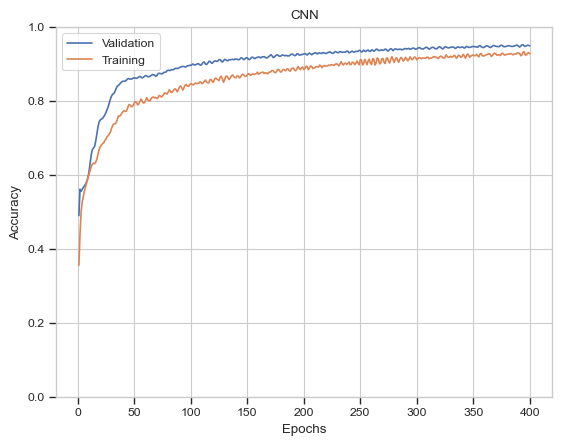

In [31]:
plt.figure()
X = list(range(1, n_epochs+1))
Y = total_acc
Y2 = val_total_acc 
plt.plot(X,Y2, label= "Validation")
plt.plot(X,Y, label = "Training")
plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN")
plt.legend()

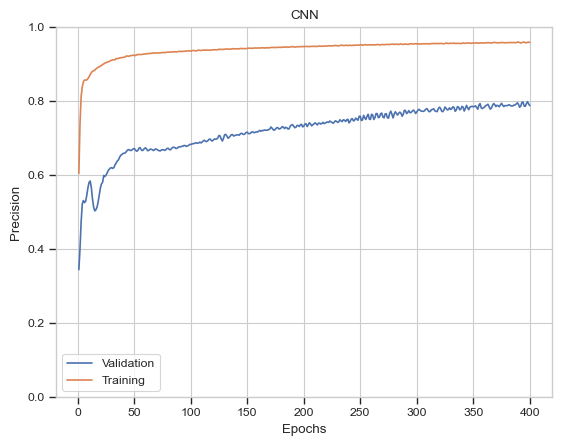

In [32]:
plt.figure()
X = list(range(1, n_epochs+1))
Y = total_pre
Y2 = val_total_pre 
plt.plot(X,Y2, label= "Validation")
plt.plot(X,Y, label = "Training")
plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("CNN")
plt.legend()

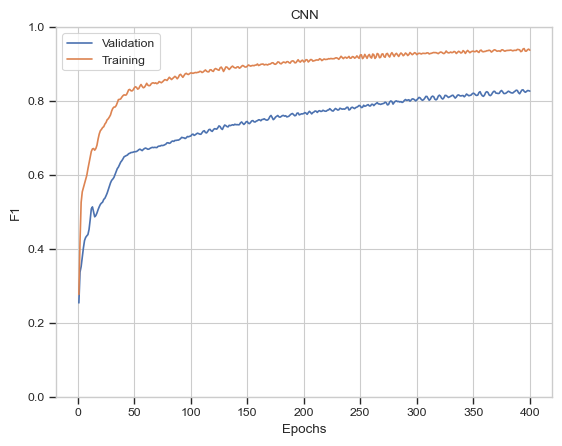

In [33]:
plt.figure()
X = list(range(1, n_epochs+1))
Y = total_f1
Y2 = val_total_f1 
plt.plot(X,Y2, label= "Validation")
plt.plot(X,Y, label = "Training")
plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("F1")
plt.title("CNN")
plt.legend()

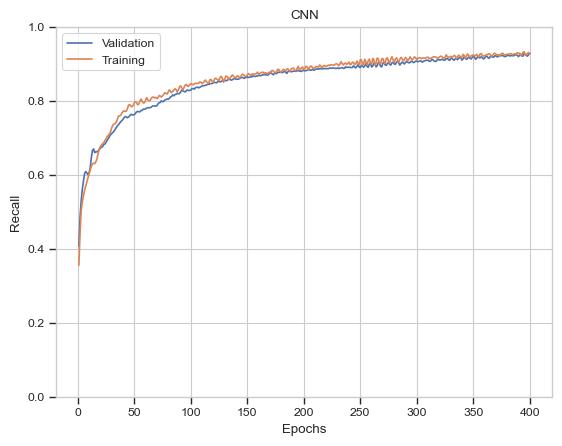

In [34]:
plt.figure()
X = list(range(1, n_epochs+1))
Y = total_rec
Y2 = val_total_rec
plt.plot(X,Y2, label= "Validation")
plt.plot(X,Y, label = "Training")
plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("CNN")
plt.legend()

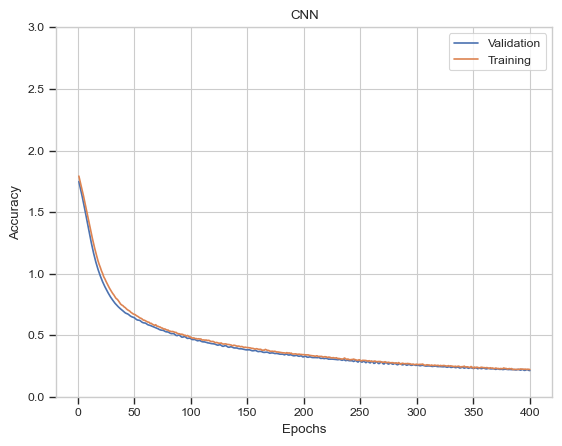

In [35]:
plt.figure()
X = list(range(1, n_epochs+1))
Y = total_loss
Y2 = val_total_loss 
plt.plot(X,Y2, label= "Validation")
plt.plot(X,Y, label = "Training")
plt.ylim(0,3)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN")
plt.legend()

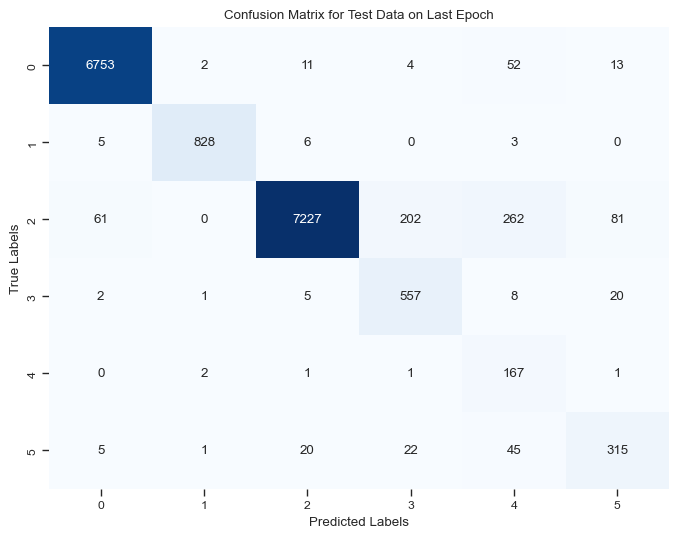

In [36]:
conf_matrix= confusion_matrix(y_val,y_preds_val)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=np.arange(conf_matrix.shape[0]), 
            yticklabels=np.arange(conf_matrix.shape[0]))

plt.title('Confusion Matrix for Test Data on Last Epoch')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

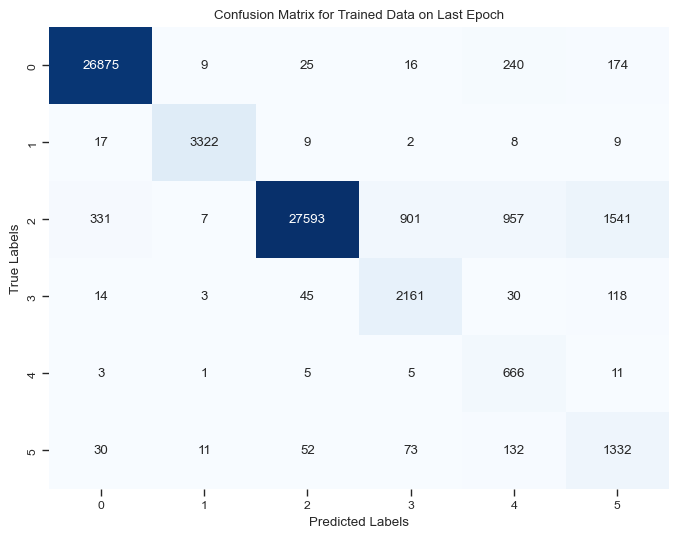

In [37]:
conf_matrix= confusion_matrix(y_trained,y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=np.arange(conf_matrix.shape[0]), 
            yticklabels=np.arange(conf_matrix.shape[0]))

plt.title('Confusion Matrix for Trained Data on Last Epoch')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()